In [393]:
import iapws
from iapws import IAPWS97 as gas
import matplotlib.pyplot as plt
import numpy as np
import math as m

MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None

In [394]:
class Part_1:

    def __init__(self,p0,t0,p_middle,t_middle,pk,t_feed_water,electrical_power,internal_efficiency,
                mechanical_efficiency,generator_efficiency,p_feed_water,n,H_0,ro):
        self.p0 = p0 * MPa
        self.t0 = t0
        self.p_middle = p_middle * MPa
        self.t_middle = t_middle
        self.pk = pk * kPa
        self.t_feed_water = t_feed_water
        self.electrical_power = electrical_power * (10 ** 6)
        self.internal_efficiency = internal_efficiency
        self.mechanical_efficiency = mechanical_efficiency
        self.generator_efficiency = generator_efficiency
        self.p_feed_water = p_feed_water
        self.piso = []
        self.Thiso = []
        self.Tsiso = []
        self.Graf_c = None
        self.ro = ro
        self.H_0 = H_0
        self.n = n
        
    def avg_diameter_(self, avg_diameter):
        self.avg_diameter = avg_diameter
        return self.avg_diameter
        # погрешности
    def delta_p0(self):
        return 0.05 * self.p0
    
    def delta_p_middle(self):
        return 0.1 * self.p_middle
    
    def delta_p_1(self):
        return 0.03 * self.p_middle 
        
    def Graf_coef(self,Graf_c):
        self.Graf_c = Graf_c
        return self.Graf_c

    def real_p0(self):
        return self.p0 - self.delta_p0()
    
    def real_p1t(self):
        return self.p_middle + self.delta_p_middle()
    
    def real_p_middle(self):
        return self.p_middle - self.delta_p_1()
         
    def _point_0(self):
        return gas(P = self.p0 * unit, T=to_kelvin(self.t0))
    
    def point_0(self):
        return gas(P = self.real_p0() * unit, h=(self._point_0()).h)
    
    def point_1t(self):
        return gas(P = self.real_p1t() * unit, s=self._point_0().s)
    
    def point_1(self):
        h_1 = self.point_0().h - self.hp_heat_drop()
        return gas(P=self.real_p1t() * unit, h=h_1)
    
    def hp_heat_drop(self):
        return (self._point_0().h - self.point_1t().h) * self.internal_efficiency
        
    def _point_middle(self):
        return gas(P=self.p_middle * unit, T=to_kelvin(self.t_middle))
    
    def point_middle(self):
        return gas(P=self.real_p_middle() * unit, h=self._point_middle().h)
    
    def point_2t(self):
        return gas(P=self.pk * unit, s=self._point_middle().s)
    
    def lp_heat_drop(self):
        return (self._point_middle().h - self.point_2t().h) * self.internal_efficiency
   
    def point_2(self):
        return gas(P=self.pk * unit, h=self.point_middle().h - self.lp_heat_drop())
    
    def efficiency_hp(self):
        return (self._point_0().h - self.point_1().h) / (self._point_0().h - self.point_1t().h)
    
    def efficiency_lp(self):
        return (self._point_middle().h - self.point_2().h) / (self._point_middle().h - self.point_2t().h)
        
    def point_k_water(self):
        return (gas(P=self.pk * unit, x=0))
    
    def point_feed_water(self):
        return gas(P=self.p_feed_water , T=to_kelvin(self.t_feed_water))
    
    def coeff(self):
        return (self.point_feed_water().T - self.point_2().T) / (to_kelvin(374.2) - self.point_2().T)
    
    def efficiency(self):
        numenator_without = self.point_2().T * (self._point_middle().s - self.point_k_water().s)
        denumenator_without = (self.point_0().h - self.point_1t().h) + (self.point_middle().h - self.point_k_water().h)
        without_part = 1 - (numenator_without / denumenator_without) 
        denumenator_infinity =(self.point_0().h - self.point_1t().h) + (self.point_middle().h - self.point_feed_water().h)
        numenator_infinity = self.point_2().T * (self._point_middle().s - self.point_feed_water().s)
        infinity_part = 1 - (numenator_infinity / denumenator_infinity)
        ksi_infinity = 1 - (without_part / infinity_part)
        eff_num = self.hp_heat_drop() + self.lp_heat_drop()
        eff_denum = self.hp_heat_drop() + (self.point_middle().h - self.point_k_water().h)
        ksi = self.Graf_c * ksi_infinity
        return  (eff_num / eff_denum) * (1 / (1 - ksi))

    def inlet_mass_flow(self):
        estimated_heat_drop = self.efficiency() * ((self.point_0().h - self.point_feed_water().h) + (self.point_middle().h - self.point_1().h))
        self.G_0 = self.electrical_power / (estimated_heat_drop * 1000 * self.mechanical_efficiency * self.generator_efficiency)
        return  self.G_0
    
    def condenser_mass_flow(self):
        return  (
    self.electrical_power /
    ((self.point_2().h - self.point_k_water().h) * 1000 * self.mechanical_efficiency * self.generator_efficiency) * ((1 / self.efficiency()) - 1)
        )
    
    def P_iso(self,p,shag):
        self.piso=[]
        for i in shag:
            self.piso = self.piso + [gas(P = p,s=i).h]
        return self.piso
    
    def T_iso(self,point):
        self.Tsiso=[]
        self.Thiso=[]
        T=point.T
        P=point.P*(10**6) 
        for i in range(int(P*0.8),int(P*1.3),int((P*1.3-P*0.8)/10)):
            self.Tsiso = self.Tsiso + [gas(T = T,P=i/(10**6)).s]
            self.Thiso = self.Thiso + [gas(T = T,P=i/(10**6)).h]
        return self.Thiso,self.Tsiso

    def x_iso(self,x,P):
        P=P
        self.xhiso=[]
        self.xsiso=[]
        for i in range(int(P),int(P*10**3*5),int((P*10**3*5/25))):
            self.xhiso = self.xhiso + [gas(x = x,P=i/(10**6)).h]
            self.xsiso = self.xsiso + [gas(x = x,P=i/(10**6)).s]
        return self.xhiso,self.xsiso
 
    def plot(self):
        plt.plot([self._point_0().s,self.point_0().s,self.point_1().s],[self._point_0().h,self.point_0().h,self.point_1().h], color="orange", linewidth=3,label = 'Процесс Расширения')
        plt.plot([self._point_middle().s,self.point_middle().s,self.point_2().s], [self._point_middle().h,self.point_middle().h,self.point_2().h], color="orange", linewidth=3)
        plt.plot([self.point_1().s, self._point_middle().s], [self.point_1().h, self._point_middle().h], color="orange", linewidth=3,linestyle=":")
        plt.xlabel(r"S, $\frac{кДж}{кг * K}$", fontsize=14)
        plt.ylabel(r"h, $\frac{кДж}{кг}$", fontsize=14)
        plt.grid()
        plt.plot([self._point_0().s, self.point_1t().s], [self._point_0().h, self.point_1t().h], color="black", linewidth=3,linestyle = ":")
        plt.plot([self._point_middle().s, self.point_2t().s], [self._point_middle().h, self.point_2t().h], color="black", linewidth=3,linestyle = ":")
        plt.plot(self.point_1t().s, self.point_1t().h, marker='.', color="black")
        plt.plot(self.point_middle().s, self.point_middle().h, marker='.', color="black")
        plt.plot(self.point_0().s, self.point_0().h, marker='.', color="black")
        plt.plot(self._point_0().s, self._point_0().h, marker='.', color="black")
        plt.plot(self._point_middle().s, self._point_middle().h, marker='.', color="black")
        plt.plot(self.point_2t().s, self.point_2t().h, marker='.', color="black")
        plt.plot(self.point_1().s, self.point_1().h, marker='.', color="black")
        plt.plot(self.point_2().s, self.point_2().h, marker='.', color="black")  
        plt.text(self.point_1t().s+0.05,self.point_1t().h,"1t")
        plt.text(self.point_middle().s-0.09,self.point_middle().h,"пп")
        plt.text(self.point_0().s-0.07,self.point_0().h,"0")
        plt.text(self._point_0().s+0.05,self._point_0().h,"0`")
        plt.text(self._point_middle().s+0.05,self._point_middle().h,"пп`")
        plt.text(self.point_2t().s+0.05,self.point_2t().h,"kt")
        plt.text(self.point_1().s+0.05,self.point_1().h,"1")
        plt.text(self.point_2().s+0.05,self.point_2().h,"k")
        plt.plot([6.1,6.2,6.3,6.4],self.P_iso(23,[6.1,6.2,6.3,6.4]), color="c")
        plt.plot([6.2,6.3,6.4,6.5],self.P_iso(((self.real_p0()*unit)),(([6.2,6.3,6.4,6.5]))), color="c")
        plt.plot([6.2,6.3,6.4,6.5,6.7,6.9,7.2],self.P_iso(((self.real_p1t()*unit)),(([6.2,6.3,6.4,6.5,6.7,6.9,7.2]))), color="c")        
        plt.plot([6.5,6.7,6.9,7.2,7.3,7.4,7.5],self.P_iso(((self.real_p_middle()*unit)),(([6.5,6.7,6.9,7.2,7.3,7.4,7.5]))), color="c")       
        plt.plot([6.5,6.7,6.9,7.2,7.3,7.4,7.5],self.P_iso(((3.5)),(([6.5,6.7,6.9,7.2,7.3,7.4,7.5]))), color="c",label = 'Изобара')       
        plt.plot([7.2,7.3,7.4,7.5,7.7,8,8.2],self.P_iso(((self.pk*unit)),(([7.2,7.3,7.4,7.5,7.7,8,8.2]))), color="c")
        plt.plot(self.T_iso(self.point_0())[1],self.T_iso(self.point_0())[0], color="g",label = 'Изотерма')
        plt.plot(self.T_iso(self._point_0())[1],self.T_iso(self._point_0())[0], color="g")
        plt.plot(self.T_iso(self.point_1())[1],self.T_iso(self.point_1())[0], color="g")
        plt.plot(self.T_iso(self.point_1t())[1],self.T_iso(self.point_1t())[0], color="g")
        plt.plot(self.T_iso(self.point_middle())[1],self.T_iso(self.point_middle())[0], color="g")
        plt.plot(self.T_iso(self._point_middle())[1],self.T_iso(self._point_middle())[0], color="g")
        plt.plot(self.x_iso(self.point_2t().x,self.pk)[1],self.x_iso(self.point_2t().x,self.pk)[0],color="grey",label = 'Линия сухости')
        plt.plot(self.x_iso(self.point_2().x,self.pk)[1],self.x_iso(self.point_2().x,self.pk)[0],color="grey")
        plt.plot(self.x_iso(1,self.pk)[1],self.x_iso(1,self.pk)[0],color="grey")
        plt.text(self.point_2().s-2,self.point_2().h+100,"X = 0.852")
        plt.text(self.point_2t().s-0.7,self.point_2().h+200,"X = 0.938")
        plt.text(self.point_2().s-1.5,self.point_2().h+400,"X = 1")        
        plt.legend()
        plt.show()

    def speed(self):
        self.u = m.pi * self.avg_diameter * self.n 
        return self.u

    def parametr_for_nozzle(self):
        self.speed()
        self.inlet_mass_flow()
        self.Ho_c = (1 - self.ro) * self.H_0
        self.Ho_p = self.H_0 * self.ro
        self.h1t = self.point_0().h - self.Ho_c
        self.c1t = m.sqrt(2 * self.Ho_c * 1000)
        self.point_1_t = gas(h = self.h1t, s = self.point_0().s)
        k = 1.4
        self.a1t = m.sqrt(k * (self.point_1_t.P * MPa) * self.point_1_t.v)
        self.M1t = self.c1t / self.a1t
        self.mu1 = 0.97
        self.F1_ = (self.G_0 * self.point_1_t.v) / (self.mu1 * self.c1t)
        return self.Ho_c, self.Ho_p, self.h1t, self.c1t, self.a1t, self.M1t, self.F1_, self.point_1_t
    
    def M1t_(self):
        self.parametr_for_nozzle()
        return self.M1t
    
    def selection_sopl(self,alpha0,alpha1_e,t_opt,M1t_,b1,f1,I1_min,W1_min):
        self.alpha0 = alpha0
        self.alpha1_e = alpha1_e
        self.t_opt = t_opt
        self.M1t_ = M1t_
        self.b1 = b1
        self.f1 = f1
        self.I1_min = I1_min
        self.W1_min = W1_min
        return self.alpha1_e, self.alpha0, self.t_opt, self.M1t_, self.b1, self.f1, self.I1_min ,self.W1_min
        
    def obrobotka_nozzle(self):
        self.parametr_for_nozzle()    
        self.el1 = self.F1_ / (m.pi * self.avg_diameter * m.sin(m.radians(self.alpha1_e)))
        self.e_opt = 4 * m.sqrt(self.el1)
        if self.e_opt > 0.85:
            self.e_opt = 0.85  
        self.l1 = self.el1 / self.e_opt
        self.mu1 = 0.982 - 0.005 * ((self.b1 * 10**-3) / self.l1)
        self.F1 = (self.G_0 * self.point_1_t.v) / (self.mu1 * self.c1t)
        self.t1opt_ = 0.75
        self.z1 = (m.pi * self.avg_diameter * self.e_opt) / (self.b1 * 10**-3  * self.t1opt_)  
        self.z_1 = round(self.z1+0.5)-1 if (round(self.z1) % 2) else round(self.z1+0.5)
        self.t1opt = (m.pi * self.avg_diameter * self.e_opt) / (self.b1 * 10**-3  * self.z_1)
        return self.el1, self.e_opt, self.l1, self.mu1, self.F1, self.z_1, self.t1opt, self.z1
    
    def nozzle_atlas(self,ksi_noz,ksi_sum):
        self.ksi_noz = ksi_noz
        self.ksi_sum = ksi_sum
    
    def nozzle_atlas_obr(self):
        self.obrobotka_nozzle()
        self.alpha_ust = self.alpha1_e - 16 * (self.t1opt - 0.75) + 23.1 
        self.b1_l1 = (self.b1 * 10 ** -3) / self.l1
        self.ksi_end_noz = self.ksi_sum - self.ksi_noz 
        self.fi = m.sqrt(1 - self.ksi_sum)  
        self.fi_ = 0.98 - 0.008 * (self.b1 * 10 ** -3 / self.l1) 
        self.delta_fi = (self.fi - self.fi_) / self.fi 
        self.c_1 = self.c1t * self.fi 
        self.alpha_1 = m.degrees(m.asin((self.mu1/self.fi)* m.sin(m.radians(self.alpha1_e))))
        return self.alpha_ust, self.b1_l1, self.ksi_end_noz, self.fi, self.fi_, self.delta_fi, self.c_1, self.alpha_1
    
    def for_selection(self):
        self.nozzle_atlas_obr()
        self.w_1 = m.sqrt(self.c_1 ** 2 + self.u ** 2 - 2 * self.c_1 * self.u * m.cos(m.radians(self.alpha_1)))
        self.beta_1 = m.degrees(m.atan(m.sin(m.radians(self.alpha_1)) / (m.cos(m.radians(self.alpha_1)) - self.u / self.c_1)))
        self.delta_Hc = self.c1t ** 2 / 2 * (1 - self.fi ** 2) / 1000  
        self.h1 = self.point_1_t.h + self.delta_Hc
        self.point_1_ = gas(P = self.point_1_t.P, h = self.h1)  
        self.h2t = self.point_1_.h - self.Ho_p
        self.point_2_t = gas(s = self.point_1_.s, h = self.h2t)
        self.w2t = m.sqrt(2000 * self.Ho_p + self.w_1 ** 2)
        self.delta = 0.004
        self.l2 = self.l1 + self.delta  
        self.k2 = 1.3
        self.a2t = m.sqrt(self.k2 * (self.point_2_t.P * MPa) * self.point_2_t.v)
        self.M2t = self.w2t / self.a2t
        return self.w_1, self.beta_1, self.point_1_, self.point_2_t, self.w2t, self.l2, self.a2t, self.M2t, self.delta_Hc

    def Raboch_Resh(self):
        self.for_selection()
        print("betta_1 = " , self.beta_1 , "M2t = " ,self.M2t )
    
    def zd_b2(self,b2):
        self.b2 = b2 
        return self.b2

    def selection_working(self,beta0,beta2_e,t_opt,M2t_,f2,I2_min,W2_min,b2_atl):
        self.for_selection()
        self.b2_atl = b2_atl
        self.beta0 = beta0
        self.beta2_e = beta2_e
        self.t2opt = t_opt
        self.M2t_ = M2t_
        self.f2 = f2
        self.I2_min = I2_min
        self.W2_min = W2_min
        return self.beta0, self.beta2_e, self.t2opt, self.M2t_, self.f2, self.I2_min, self.W2_min, self.b2_atl
    
    def Spec_work(self):
        self.for_selection()
        self.mu2 = 0.965 - 0.01 * (self.b2 * 10 ** -3 / self.l2)
        self.F2 = (self.G_0 * self.point_2_t.v) / (self.mu2 * self.w2t)
        self.beta2_e = m.degrees(self.F2 / (self.e_opt * m.pi * self.avg_diameter * self.l2))
        self.z2 = (m.pi * self.avg_diameter) / (self.b2 * 10 ** -3 * self.t2opt)
        self.z_2 = round(self.z2+0.5)-1 if (round(self.z2) % 2) else round(self.z2+0.5)
        self.t2opt = (m.pi * self.avg_diameter) / (self.b2 * 10 ** -3 * self.z2)
        self.beta2_ust = self.beta2_e - 20.5 * (self.t2opt - 0.60) + 47.1
        self.b2_l2 = (self.b2 * 10 ** -3) / self.l2  
        return self.z_2, self.t2opt, self.beta2_ust, self.b2_l2 ,self.F2 ,self.beta2_e ,self.mu2
    
    def proverka_resh(self):
        self.Spec_work()
        print("betta2_e = ", self.beta2_e)
        
    def b_l_and_M1t_nozzle(self):
        self.Spec_work()
        return self.b1_l1,self.M1t 
        
    def b_l_and_M2t_work(self):
        self.Spec_work()
        return self.b2_l2, self.M2t
        
    
    def working_atlas(self,ksi_grid,ksi_sum_g):
        self.ksi_grid = ksi_grid
        self.ksi_sum_g = ksi_sum_g
        return self.ksi_grid,self.ksi_sum_g
    
    def working_atlas_obr(self):
        self.Spec_work()
        self.ksi_end_grid = self.ksi_sum_g - self.ksi_grid
        self.psi = m.sqrt(1 - self.ksi_sum_g)
        self.psi_ = 0.96 - 0.014 * (self.b2 * 10 ** -3 / self.l2)
        self.delta_psi = (self.psi - self.psi_) / self.psi
        self.w_2 = self.w2t * self.psi
        self.beta_2 = m.degrees(m.asin((self.mu2 / self.psi) * m.sin(m.radians(self.beta2_e))))
        self.c_2 = m.sqrt(self.w_2 ** 2 + self.u ** 2 - 2 * self.w_2 * self.u * m.cos(m.radians(self.beta_2)))
        self.alpha_2 = m.degrees(m.atan((m.sin(m.radians(self.beta_2))) / (m.cos(m.radians(self.beta_2)) - self.u / self.w_2)))
        return self.ksi_end_grid, self.psi, self.psi_, self.delta_psi, self.beta_2, self.c_2,self.alpha_2, self.w_2

    def construction_of_velocity_triangles(self):
        self.working_atlas_obr()
        sin_alpha_1 = m.sin(m.radians(self.alpha_1))
        cos_alpha_1 = m.cos(m.radians(self.alpha_1))
        sin_beta_2 = m.sin(m.radians(self.beta_2))
        cos_beta_2 = m.cos(m.radians(self.beta_2))
        c1_plot = [[0, -self.c_1 * cos_alpha_1], [0, -self.c_1 * sin_alpha_1]]
        u1_plot = [[-self.c_1 * cos_alpha_1, -self.c_1 * cos_alpha_1 + self.u], [-self.c_1 * sin_alpha_1, -self.c_1 * sin_alpha_1]]
        w1_plot = [[0, -self.c_1 * cos_alpha_1 + self.u], [0, -self.c_1 * sin_alpha_1]]
        w2_plot = [[0, self.w_2 * cos_beta_2], [0, -self.w_2 * sin_beta_2]]
        u2_plot = [[self.w_2 * cos_beta_2, self.w_2 * cos_beta_2 - self.u], [-self.w_2 * sin_beta_2, -self.w_2 * sin_beta_2]]
        c2_plot = [[0, self.w_2 * cos_beta_2 - self.u], [0, -self.w_2 * sin_beta_2]]
        fig, ax = plt.subplots(1, 1, figsize=(15, 5))
        ax.plot(c1_plot[0], c1_plot[1], label='C_1', c='red')
        ax.plot(u1_plot[0], u1_plot[1], label='u_1', c='blue')
        ax.plot(w1_plot[0], w1_plot[1], label='W_1', c='green') 
        ax.plot(w2_plot[0], w2_plot[1], label='W_2', c='green')
        ax.plot(u2_plot[0], u2_plot[1], label='u_2', c='blue')
        ax.plot(c2_plot[0], c2_plot[1], label='C_2', c='red')
        ax.set_title("Треугольник скоростей",)
        ax.legend()
        ax.grid();

    def u_cf_c(self): 
        self.working_atlas_obr()   
        self.cf = m.sqrt(2000 * self.H_0)
        self.u_cf = self.u / self.cf
        self.u_cf_opt = self.fi * m.cos(m.radians(self.alpha_1)) / (2 * m.sqrt(1 - self.ro))
        return self.cf, self.u_cf, self.u_cf_opt

    def KPD(self):  
        self.u_cf_c()  
        self.delta_Hp = self.w2t ** 2 / 2 * (1 - self.psi ** 2) / 1000
        self.h2 = self.point_2_t.h + self.delta_Hp
        self.point_2_ = gas(P = self.point_2_t.P, h = self.h2)        
        self.delta_Hvc = self.c_2 ** 2 / 2 / 1000 
        self.x_vc = 0
        self.E0 = self.H_0 - self.x_vc * self.delta_Hvc  
        self.eff = (self.E0 - self.delta_Hc - self.delta_Hp - (1 - self.x_vc) * self.delta_Hvc) / self.E0
        self.point_t_konec = gas(h = self.point_2_.h - self.E0, P = self.point_2_.P)
        self.eff_ = (self.u * (self.w_1 * m.cos(m.radians(self.beta_1)) + self.w_2 * m.cos(m.radians(self.beta_2)))) / self.E0 / 1000
        self.delta_eff = (self.eff - self.eff_) / self.eff
        return self.delta_Hp, self.delta_Hvc, self.E0, self.eff, self.eff_, self.delta_eff, self.point_2_, self.point_t_konec

    def delta_graf(self):
        self.KPD()
        print("Погрешность расчета КПД по разным методам = ",self.delta_eff*100,"%")
    
    def gr_u_cf(self):  
        self.KPD()
        
        array_u_cf = []
        H0_values = []
        efficiency_ = []
        efficiency = []           
        for H_val in range (50,120,1):   
            self.H_0 = float(H_val)  
            self.KPD()
            array_u_cf = array_u_cf + [self.u_cf] 
            H0_values = H0_values + [self.H_0]
            efficiency_ = efficiency_ + [self.eff_]
            efficiency = efficiency + [self.eff]
            
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        X1 = array_u_cf
        X2 = H0_values
        Y1 = efficiency_
        Y2 = efficiency
        ax.plot(X1,Y1, label = 'Расчет по методу скоростей', color = 'blue', linewidth=3,linestyle=":")
        ax.plot(X1,Y2, label = 'Расчет по методу потерь', color = 'red')
        ax.set_title("Зависимость лопаточного КПД от u/сф")
        ax.set_ylabel("Лопаточный КПД")
        ax.set_xlabel("U/сф")
        ax.legend()
        ax.grid()
        plt.show()
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        plt.plot(X2,Y1, label = 'Расчет по методу скоростей', color = 'blue',linewidth=3,linestyle=":")
        plt.plot(X2,Y2, label = 'Расчет по методу потерь', color = 'red')
        plt.title("Зависимость лопаточного КПД от H0")
        plt.ylabel("Лопаточный КПД")
        plt.xlabel("H0")
        plt.legend()
        plt.grid()
        plt.show()
   
    def param_kpd(self):
        self.KPD()
        self.peripheral_diameter = self.avg_diameter + self.l2
        self.mu_a = 0.5
        self.delta_a = 0.0025
        self.mu_r = 0.75
        self.delta_r = 0.001 * self.peripheral_diameter
        self.z = 12 # по прототипу
        self.delta_e = m.pow((1 / (self.mu_a * self.delta_a) ** 2) + (self.z / (self.mu_r * self.delta_r) ** 2), -0.5)
        self.ksi_bandage = ((m.pi *self.peripheral_diameter *self.delta_e * self.eff) /self.F1) * m.sqrt(self.ro + 1.8 * self.l2 / self.avg_diameter)
        self.deltaH_y = self.ksi_bandage * self.E0
        self.k_tr = 0.7 * 10 ** -3
        self.ksi_friction = self.k_tr * m.pow(self.avg_diameter, 2) / self.F1 * m.pow(self.u_cf, 3)
        self.deltaH_tr = self.ksi_friction * self.E0
        self.k_v = 0.065
        self.m_ = 1
        self.ksi_v = self.k_v / m.sin(m.radians(self.alpha1_e)) * (1 - self.e_opt) / self.e_opt * m.pow(self.u_cf, 3) * self.m_
        self.B2 = self.b2 * m.sin(m.radians(self.beta2_ust))
        self.i = 4
        self.ksi_segment = 0.25 * self.B2 * 10**-3 * self.l2 / self.F1 * self.u_cf * self.eff * self.i
        self.ksi_partiality = self.ksi_v + self.ksi_segment
        self.deltaH_partiality = self.ksi_partiality * self.E0
        return self.peripheral_diameter, self.delta_r, self.delta_e, self.ksi_bandage, self.deltaH_y, self.ksi_friction, self.deltaH_tr, self.ksi_v, self.B2, self.ksi_segment, self.ksi_partiality, self.deltaH_partiality 

    def kpd_i(self):
        self.param_kpd()
        self.x_vc = 0
        self.H_i = self.E0 - self.delta_Hc - self.delta_Hp - (1 - self.x_vc) * self.delta_Hvc - self.deltaH_y - self.deltaH_tr - self.deltaH_partiality
        self.internal_eff = self.H_i / self.E0
        self.N_i = self.G_0 * self.H_i
        return self.H_i, self.internal_eff, self.N_i

    def Proncnost(self):
        self.kpd_i()
        self.W2_min_ = self.W2_min * m.pow(self.b2 / self.b2_atl, 3)
        self.sigma_bending = (self.G_0 * self.H_0 * 1000 * self.eff * self.l2) / (2 * self.u * self.z_2 * self.W2_min_ * self.e_opt)
        self.omega = 2 * m.pi * self.n
        self.sigma_stretching = (0.5 * 7800 * (self.omega ** 2) * self.avg_diameter * self.l2) / (10**6)
        return self.W2_min_, self.sigma_bending, self.omega, self.sigma_stretching
    
    def sigma_bend(self):
        self.Proncnost()
        return self.sigma_bending
    
    def sigma_stretch(self):
        self.Proncnost()
        return self.sigma_stretching

    def for_b2(self):
        self.Proncnost()
        new_b2 = self.b2*m.sqrt(self.sigma_bending/20)
        return new_b2
    
    def graf_rash(self):
        plt.plot(self.point_t_konec.s, self.point_t_konec.h, marker='.', color="black")
        plt.plot([6.25,6.26,6.27,6.3],self.P_iso(self.point_0().P,[6.25,6.26,6.27,6.3]), color="c",label = 'Изобара')
        plt.plot([6.25,6.26,6.27,6.3],self.P_iso(((self.point_2_.P)),(([6.25,6.26,6.27,6.3]))), color="c")
        plt.plot([6.25,6.26,6.27,6.3],self.P_iso(((self.point_1_.P)),(([6.25,6.26,6.27,6.3]))), color="c")
        plt.xlabel(r"S, $\frac{кДж}{кг * K}$", fontsize=14)
        plt.ylabel(r"h, $\frac{кДж}{кг}$", fontsize=14)
        plt.title("Процесс расширения в регулирующей ступени")
        plt.legend()
        plt.grid()
        plt.show()

    def stages(self, n_stages):
        self.n_stages = n_stages
        return self.n_stages
              
    def start(self): 
        self.Proncnost()
        self.diametr1 = self.avg_diameter - 0.2
        self.root_diameter = self.diametr1 - self.l2
        self.l2z = (-self.root_diameter + m.sqrt(self.root_diameter**2 + 4 * self.point_1().v / self.point_1_ .v * self.l2 * self.peripheral_diameter))/2
        self.dz2 = self.root_diameter + self.l2z
        return self.root_diameter , self.l2z , self.dz2 , self.l2

    def nextg(self , number_turb):
        self.start()
        self.diametrs = (-self.diametr1 + self.dz2) / self.n_stages * number_turb + self.diametr1
        self.blade_lengths = (-self.l2 + self.l2z) / self.n_stages * number_turb + self.l2
        return self.diametrs , self.blade_lengths 

    def H0_(self):
        self.ucf = []
        self.H0 = []
        for kkk in range (0,self.n_stages):
            self.nextg(kkk)
            reaction_degree = self.ro + (1.8 / (self.diametrs / self.blade_lengths + 1.8))
            u_cf_n = self.fi * m.cos(m.radians(self.alpha_1)) /  (2 * (1 - reaction_degree) ** 0.5)
            first = (self.diametrs / (u_cf_n)) ** 2
            second = (self.n / 50) ** 2
            if kkk == 0:
                self.H0 = self.H0 + [ 12.3 * first * second ] 
            else:                
                self.H0 = self.H0 + [0.94 * 12.3 * first * second ]
        return self.H0
    
    def sueta(self):
        self.H0_()
        return self.fi

    def reheat_(self):
        self.H0_()
        self.reheat_factor = 4.8 * 10 ** (-4) * (1 - self.internal_eff) * (self.point_1_.h - self.point_1().h) * (self.n_stages - 1) / self.n_stages

    def z_proverka(self):
        self.reheat_()
        self.H0_poln = 0
        aue = 0
        for ttt in range (-1,self.n_stages-1):
            self.H0_poln = self.H0_poln + self.H0[ttt] 
        self.z_z = ((self.point_1_.h - self.point_1().h)* (1 + self.reheat_factor))/(self.H0_poln/(self.n_stages))
        return self.z_z

    def real_heat_drop(self):
        self.z_proverka()
        bias = (self.hp_heat_drop() * (1 + self.reheat_factor) - self.H0_poln) / self.n_stages
        self.new_actual_heat_drop = []
        for k in range(0,self.n_stages):
            self.new_actual_heat_drop = self.new_actual_heat_drop + [self.H0[k] + bias]
        return self.new_actual_heat_drop

    def Heat_drop_proverka(self):
        self.real_heat_drop()
        summ = 0
        for i in range(0,self.n_stages):
            summ = summ + self.new_actual_heat_drop[i]
        print("Процентная разница между суммарным теплоперепадом на ступенях и полным теплоперепадом на ЦВД",(summ-self.hp_heat_drop())/summ)  

    def for_plot(self):
        self.real_heat_drop()
        d_plot = []
        ucf_plot = []
        veernost_plot = []
        react_plot = []
        blade_plot = []
        for i in range (0,self.n_stages):
            d_plot = d_plot + [self.nextg(i)[0]]
            blade_plot = blade_plot + [self.nextg(i)[1]]
            veernost_plot = veernost_plot + [self.nextg(i)[0]/self.nextg(i)[1]]
            react_plot = react_plot + [self.ro + (1.8 / (self.nextg(i)[0]/self.nextg(i)[1] + 1.8))]
            ucf_plot = ucf_plot + [self.fi * m.cos(m.radians((self.alpha_1))) /  (2 * (1 -(self.ro + (1.8 / (self.nextg(i)[0]/self.nextg(i)[1] + 1.8))))**0.5)]
        
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        X1 = range(1,self.n_stages+1)
        Y1 = d_plot
        Y2 = blade_plot
        Y3 = veernost_plot
        Y4 = react_plot      
        Y5 = ucf_plot
        Y6 = self.new_actual_heat_drop
        ax.plot(X1,Y1, color = 'k')
        ax.set_title("Зависимость диаметра лопаток от номера ступени")
        ax.set_ylabel("Диаметр")
        ax.set_xlabel("z")
        ax.plot(range(1, self.n_stages + 1), Y1,  marker='o')
        ax.grid()
        plt.show()
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.plot(X1,Y2, color = 'k')
        plt.title("Зависимость длинны лопаток от номера ступени")
        plt.ylabel("Длинна лопатки")
        plt.xlabel("z")
        ax.plot(range(1, self.n_stages + 1), Y2,  marker='o')
        plt.grid()
        plt.show()
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.plot(X1,Y3, color = 'k')
        plt.title("Зависимость d/l от номера ступени")
        plt.ylabel("d/l")
        plt.xlabel("z")
        ax.plot(range(1, self.n_stages + 1), Y3,  marker='o')
        plt.grid()
        plt.show()
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.plot(X1,Y4, color = 'k')
        plt.title("Зависимость степени реактивности от номера ступени")
        plt.ylabel("Степень реактивности")
        plt.xlabel("z")
        ax.plot(range(1, self.n_stages + 1), Y4,  marker='o')
        plt.grid()
        plt.show()
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.plot(X1,Y5, color = 'k')
        plt.title("Зависимость u/cf от номера ступени")
        plt.ylabel("u/cf")
        plt.xlabel("z")
        ax.plot(range(1, self.n_stages + 1), Y5,  marker='o')
        plt.grid()
        plt.show()
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.plot(X1,Y6, color = 'k')
        plt.title("Зависимость теплоперепада от номера ступени")
        plt.ylabel("H")
        plt.xlabel("z")
        ax.plot(range(1, self.n_stages + 1 ), Y6,  marker='o')
        plt.grid()
        plt.show()
    
    def bend_last(self):
        self.z_proverka()
        self.density = 7800 
        self.max_stress_1 = 235 * MPa
        self.tension_stress_root_func = 0.5 * self.density * (self.u ** 2) * self.dz2 * self.l2z
        return self.tension_stress_root_func , self.l2z, self.density
        
    def validate_bend(self):
        self.bend_last()
        print(f"Запас прочности: {self.max_stress_1 / self.tension_stress_root_func}")
    
    def tension_stress(self,x):       
        self.bend_last()
        r_root = (self.dz2 - self.l2z) / 2
        constant_part = self.density * (self.u ** 2)
        left = r_root * (self.l2z - x)
        right = 0.5 * ((self.l2z ** 2) - (x ** 2))
        self.tens = constant_part * (left + right)
        return self.tens
    
    def plot_tens(self):
        y = np.linspace(0, self.l2z, 100)
        fig, ax = plt.subplots(1,1,figsize=(5,5))
        ax.plot(self.tension_stress(y) / MPa, y)
        ax.set_xlabel("Напряжения растяжения, МПа")
        ax.set_ylabel("Координаты сечения вдоль высоты лопатки, м")
        ax.grid()

    def tension_disk(self):
        self.bend_last()
        nu = 0.3
        r1 = self.root_diameter
        r2 = 0.56
        sigma_1 = 0
        sigma_2 = 100 * MPa
        max_stress_2 = 510 * MPa
        r = 0
        a = (3 + nu) / 8
        sigma_r = a * self.density * (self.u ** 2) * (r2**2 - r**2) + sigma_2
        b = (1 + 3 * nu) / (3 + nu)
        sigma_theta = a * self.density * (self.u ** 2) * (r2**2 - b * r**2) + sigma_2
        print("Коэффициент запаса прочности =", max_stress_2/sigma_theta)

    def _lambda_(self):
        self.bend_last()
        mm = 1e-3
        self.m = 12
        self.t = 25 * mm
        self.beta = self.beta2_ust
        self.density = 7800
        self.E = 2 * (10**11)
        self.z = self.z_2
        self.d = self.dz2
        self.l = self.l2z
        self.F = self.f2 * (10 ** (-4))
        self.J = self.I2_min* (10 ** (-8))  #((self.b2/self.b2_atl)**4)
        self.delta = 5 * mm
        self.b = 40 * mm
        self._lambda = self.l / ((self.J / self.F) ** 0.5)
        return self._lambda

    def parametrs_(self,psi, H):
        self._lambda_()
        self.psi = psi      
        self.H = H           
        return self.psi, self.H
           
    def Fi_graf(self, fi_graf):
        self.fi_graf = fi_graf
        return (self.fi_graf)       
    
    def k_and_nu(self):
        self._lambda_()
        self.J_b = self.b * (self.delta ** 3) / 12
        self.k = (12 * (self.m - 1) * self.H * self.E * self.J_b * self.l * np.sin(np.deg2rad(self.beta)) ** 2) / (self.m * self.t * self.J * self.E)
        self.nu = self.b * self.delta * self.t / (self.F * self.l)
        self.B_bandage = 0.5 * ((self.d/self.l) - 1) * ((self.nu+1/2)/(self.nu+1/3)) + np.sin(np.deg2rad(self.beta)) ** 2
        return self.k, self.nu
    
    def static_frequency(self,i):
        self.k_and_nu()
        _m = {
        1: 0.56,
        2: 3.51,
        3: 9.82
         }
        first = self.psi * _m[i] / (self.l ** 2)
        second = ((self.E * self.J) / ((self.density * self.F))) ** 0.5
        return first * second
    
    def to_dynamic_frequency(self,F,n):
        self.k_and_nu()
        root = (1 + self.B_bandage * (n / F) ** 2) ** 0.5
        return F * root

    def min_max(self,F, delta=0.05):
        self.k_and_nu()
        return F * (1 - delta) , F * (1 + delta)
    
    def k_line(self, k, n_line):
        return k * n_line
    
    def vibr_plot(self):
        f_a0 = self.static_frequency(1) * self.fi_graf
        n_line = np.linspace(0, 60)
        min_line_a0, max_line_a0 = self.min_max(self.to_dynamic_frequency(f_a0, n_line))
        fig, ax = plt.subplots(1,1,figsize=(15,10))
        ax.plot(n_line, self.to_dynamic_frequency(f_a0, n_line), label='$f_{a0}$')
        ax.fill_between(n_line, y1=min_line_a0, y2=max_line_a0, alpha=0.5)
        ax.plot(n_line, self.k_line(1,n_line), label=f'k={1}')
        ax.plot(n_line, self.k_line(4,n_line), label=f'k={4}')
        ax.plot(n_line, self.k_line(7,n_line), label=f'k={7}')
        ax.plot(n_line, self.k_line(9,n_line), label=f'k={9}')
        ax.set_xlabel("n, rps")
        ax.set_ylabel("f, Hz")
        ax.grid()
        ax.legend()
        ax.set_title("Вибрационная диаграмма");
    
    def rotor_(self,L ,L_rotor,d,d_0, rotor_mass):
        n = 50
        diameter = 470  # in mm
        L = 4.945  # in m
        mass = 9936  # in kg
        numenator = (diameter / L) ** 2
        denumenator = (mass / L) ** 0.5
        n_critical  = 7.5 * numenator / denumenator
        rps = n_critical / 60 
        print(rps < n)

    
    def Rotor_stress(self, L ,L_rotor,d,d_0, rotor_mass ):
        E = 1.8 * 10**11
        density = 7800
        EI = E * np.pi * (d ** 4 - d_0 ** 4) / 64
        P_11 = (np.pi ** 2 / L ** 2) * (EI / (rotor_mass / L_rotor)) ** 0.5
        P_12 = 4 * P_11
        delta_op = 0.5 * 10 ** -9
        C_horizontal = 0.5 * 10 ** 9
        delta_opor = delta_op + 1 / C_horizontal
        P_21 = (2 / (rotor_mass * delta_opor)) ** 0.5
        P_22 = (L / L_rotor) * 3 ** 0.5 * P_21
        P_1 = 1 / (
            (1 / P_11 ** 2) + (1 / P_21 ** 2) 
        ) ** 0.5
        P_1 / (2 * np.pi)
        P_2 = 1 / (
            (1 / P_12 ** 2) + (1 / P_22 ** 2) 
        ) ** 0.5
        print('Первая критическая частота ротора', P_1 / (2 * np.pi) ,'Вторая критическая частота ротора', P_2 / (2 * np.pi))

In [395]:
P0 = 23
t0 = 540
Ppp = 3.65
tpp = 540
Pk = 3.3
tpv = 276
N_e = 525
z = 8
p_feed_water = 1.3 * P0 
internal_efficiency = 0.85
mechanical_efficiency = 0.994
generator_efficiency = 0.99
H_0 = 90
n = 50
ro = 0.05
avg_diameter = 1.1
Dano=Part_1(P0,t0,Ppp,tpp,Pk,tpv,N_e,internal_efficiency,mechanical_efficiency,generator_efficiency,p_feed_water
            ,n,H_0,ro)

In [396]:
electrical_power = 525 * (10 ** 6)
p0 = 23 * MPa
t0 = 540
p_middle = 3.65 * MPa
t_middle = 540
pk = 3.3 * kPa
t_feed_water = 276
p_feed_water = 1.3 * p0
z = 8

internal_efficiency = 0.85
mechanical_efficiency = 0.994
generator_efficiency = 0.99


ksi_noz = 1.98 * 10 **(-2) #коэфф профильных потерь    
ksi_sum = 7 * 10 **(-2) #коэфф профильных потерь суммарный
Dano.nozzle_atlas(ksi_noz,ksi_sum)
    

In [418]:
Dano.avg_diameter_(1.1)
Dano.Graf_coef(0.83) 
Dano.Raboch_Resh()

betta_1 =  34.23578457838829 M2t =  0.4225254767496477


In [419]:
print("Массовый расход в турбину на входе", Dano.inlet_mass_flow())
print("Массовый расход в конденсатор:", Dano.condenser_mass_flow())

Массовый расход в турбину на входе 429.8600603906746
Массовый расход в конденсатор: 281.0189976920536


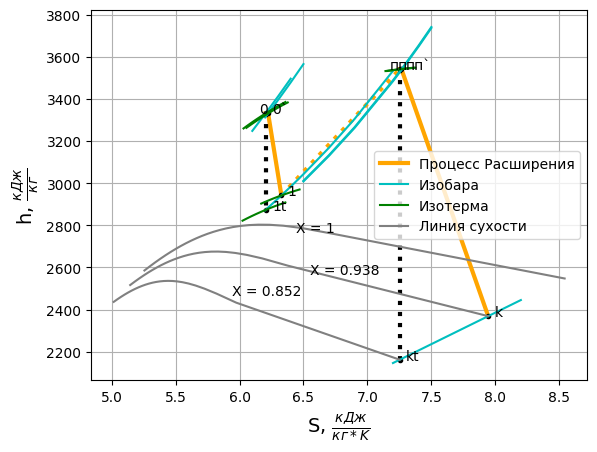

In [420]:
Dano.plot()

In [421]:
#параметры выбранной сопловой решетки С-90-18А      
alpha0 = 90
alpha1_e = 20
t_opt = 0.8
M1t_ = 0.85
b1 = 47.1
f1 = 2.72
I1_min = 0.243
W1_min = 0.333
Dano.selection_sopl(alpha0,alpha1_e,t_opt,M1t_,b1,f1,I1_min,W1_min)
Dano.avg_diameter_(1.1)

1.1

In [422]:
Dano.b_l_and_M1t_nozzle()

AttributeError: 'Part_1' object has no attribute 'b2'

In [423]:
ksi_noz = 1.98 * 10 **(-2) #коэфф профильных потерь    
ksi_sum = 6.5 * 10 **(-2) #коэфф профильных потерь суммарный
Dano.nozzle_atlas(ksi_noz,ksi_sum)

In [424]:
Dano.Raboch_Resh()

betta_1 =  34.23578457838829 M2t =  0.4225254767496477


In [425]:
#по полученным параметрам выбирем рабочую лопатку Р-26-17А
beta0 = 31
beta2_e = 19
t_opt = 0.7
M2t_ = 0.95      
b2 = 25.7
b2_atl = 25.7
f2 = 2.07
I2_min = 0.215
W2_min = 0.225
Dano.selection_working(beta0,beta2_e,t_opt,M2t_,f2,I2_min,W2_min,b2_atl)
Dano.zd_b2(b2)
Dano.proverka_resh()

betta2_e =  28.204129394439885


In [426]:
Dano.b_l_and_M2t_work()

(0.7155948555656221, 0.4225254767496477)

In [427]:
ksi_grid = 5 * 10 **(-2) #коэфф профильных потерь    
ksi_sum_g = 14 * 10 **(-2) #коэфф профильных потерь суммарный
Dano.working_atlas(ksi_grid,ksi_sum_g)

(0.05, 0.14)

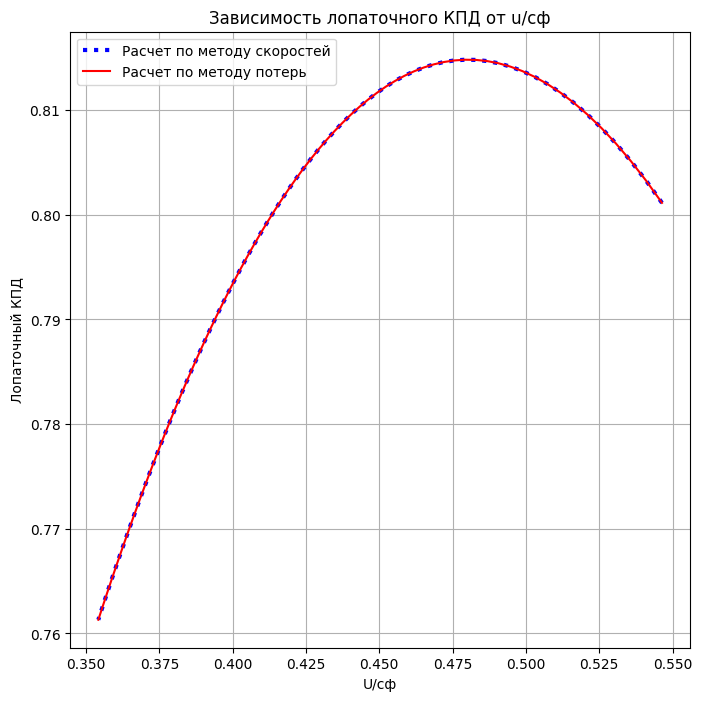

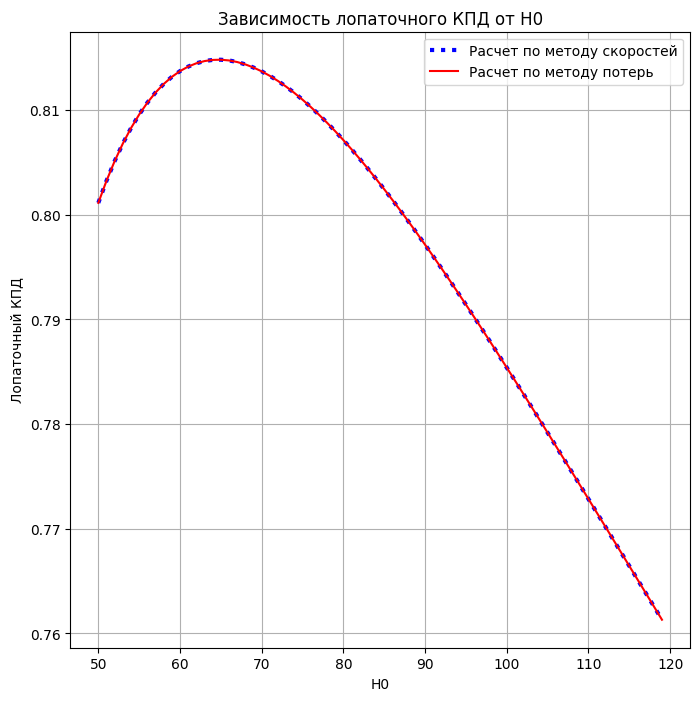

In [428]:
Dano.gr_u_cf()

In [429]:
Dano.delta_graf()
#Из данного диапазона для энтальпии [0.90-110] по графику наилучший по кпд 90
Dano.avg_diameter_(1.1)

Погрешность расчета КПД по разным методам =  -1.4583065789283615e-14 %


1.1

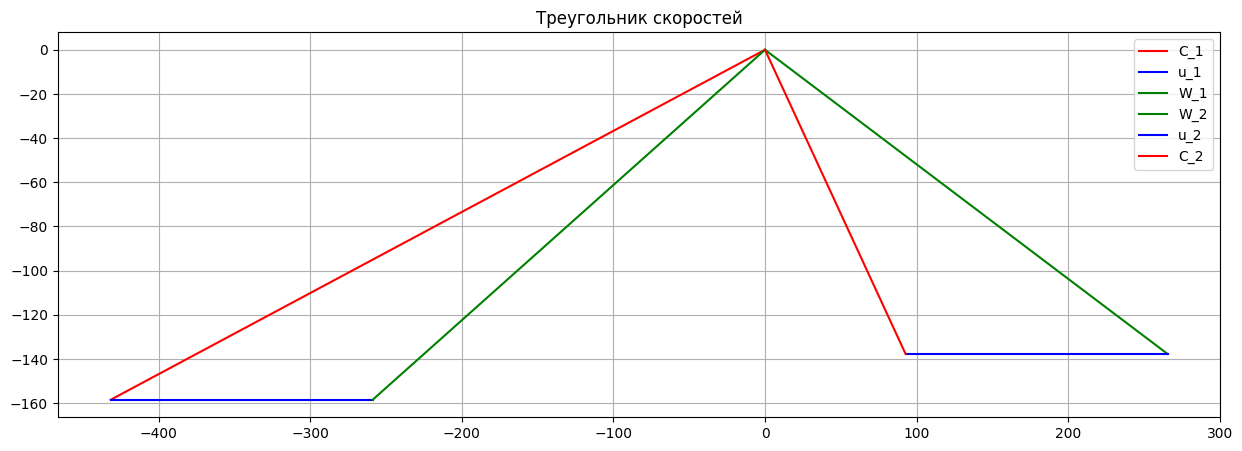

In [430]:
Dano.construction_of_velocity_triangles()

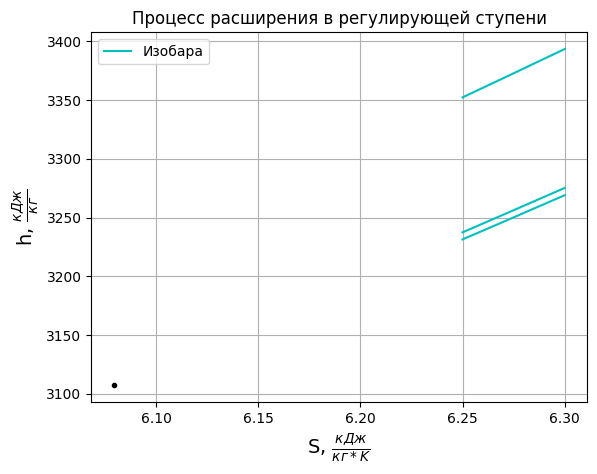

In [431]:
Dano.graf_rash()

In [432]:
Dano.sigma_bend() # < [sigma_bend] = 20 Мпа

183.21260390201687

In [433]:
Dano.for_b2() # размер проходящий по напряжению

77.78498979598928

In [434]:
Dano.sigma_stretch() # < [sigma_stretch] = 450 Мпа

14.762346261053203

In [435]:
#зададимся числом ступеней по прототипу
Dano.stages(11)

11

In [436]:
#Тогда теплоперепады по ступеням равны(с предположением, что диаметры ступеней изменяются линейно)
Dano.real_heat_drop()

[38.22355888503016,
 35.76107294760016,
 35.87765489840376,
 36.00494970483593,
 36.14242470600752,
 36.28958985727814,
 36.445993551867936,
 36.61121892462773,
 36.78488057428165,
 36.966621649891685,
 37.156111255185444]

In [437]:
Dano.z_proverka()

7.1211389204816795

In [438]:
Dano.Heat_drop_proverka()

Процентная разница между суммарным теплоперепадом на ступенях и полным теплоперепадом на ЦВД 0.032788919670163105


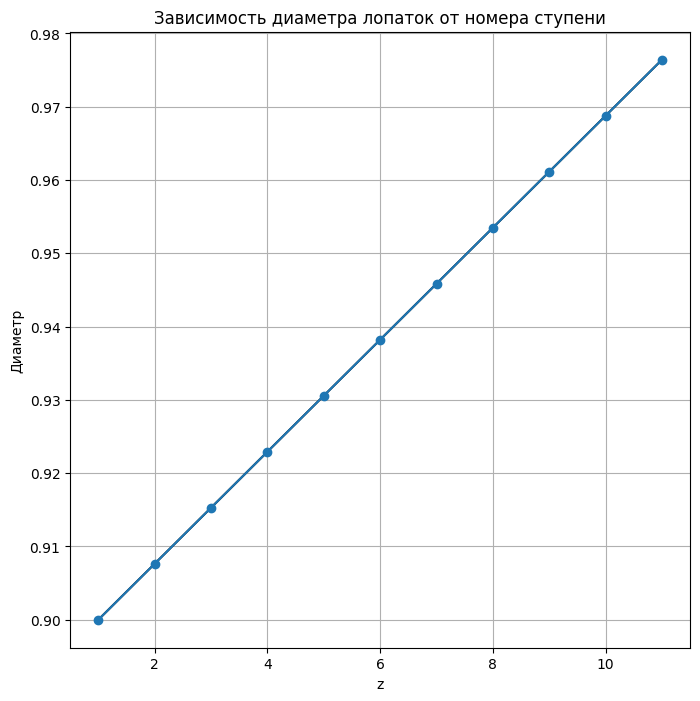

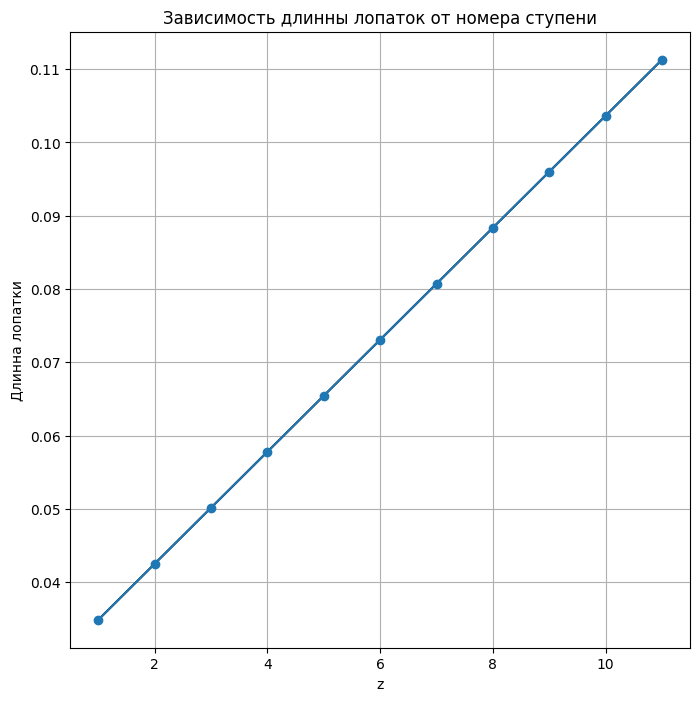

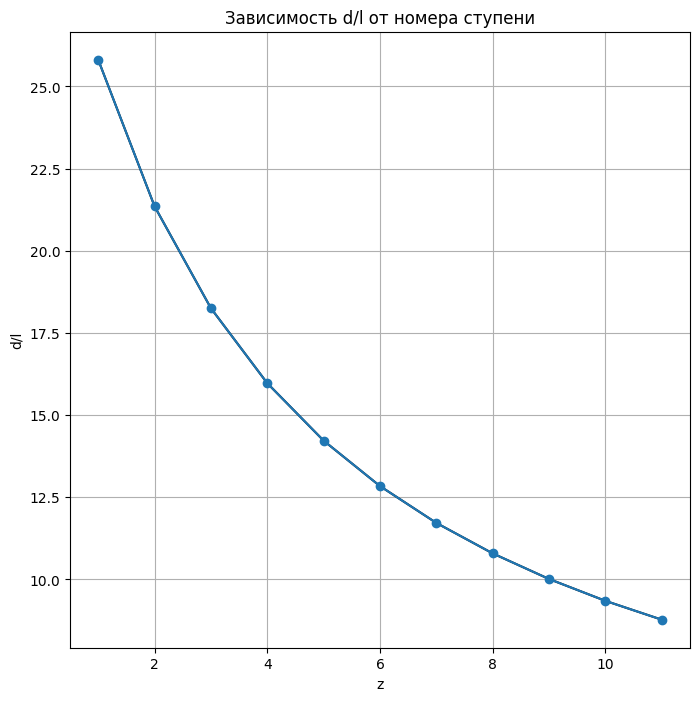

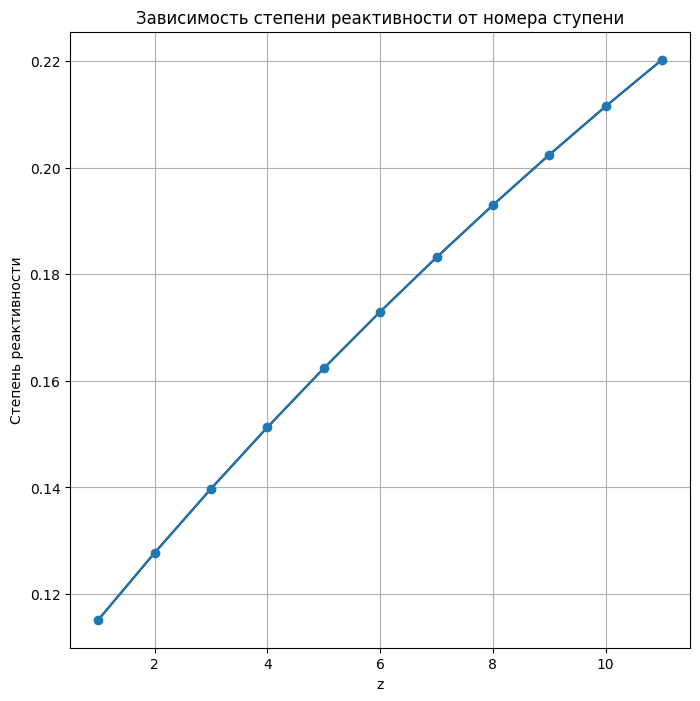

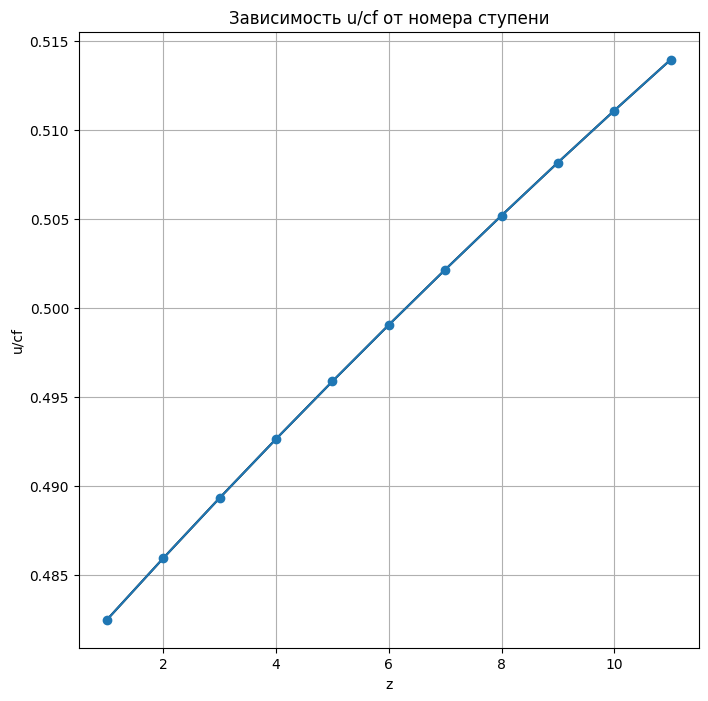

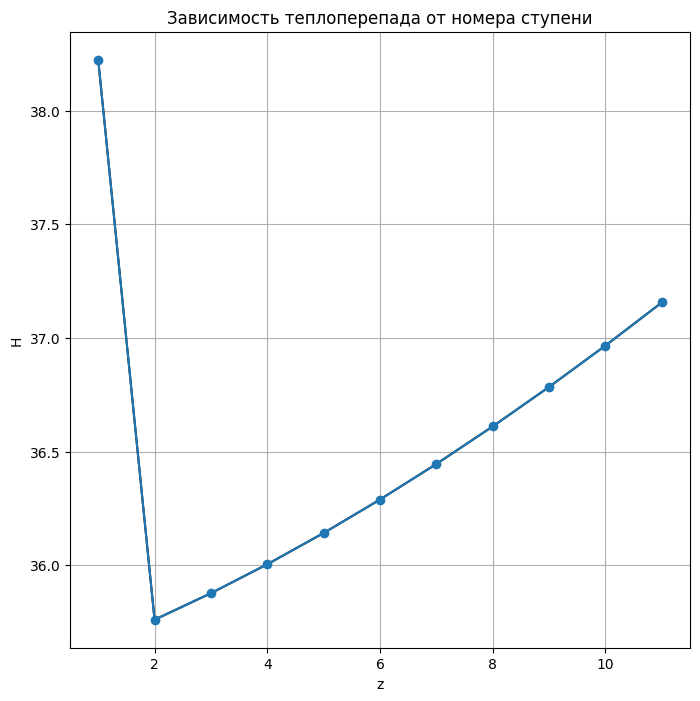

In [439]:
Dano.for_plot()

In [440]:
Dano.validate_bend()

Запас прочности: 17.246070363331096


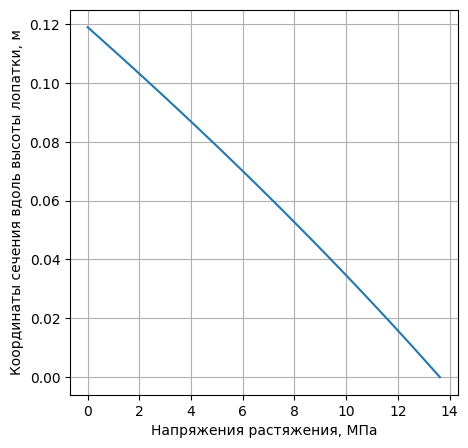

In [441]:
Dano.plot_tens()

In [442]:
Dano.tension_disk()

Коэффициент запаса прочности = 3.9193236540045855


In [443]:
#параметры взяты из построенной 3д модели
rotor_mass = 8863.458
L = 4.997
L_rotor = 5.81
d = 0.56
d_0 = 0.1

In [444]:
Dano.Rotor_stress(L,L_rotor,d,d_0,rotor_mass)

Первая критическая частота ротора 33.68158305163873 Вторая критическая частота ротора 66.68814849814487


In [445]:
Dano._lambda_()

36.90059291694176

In [446]:
#По графику примем
psi = 0.9
#возьмем бондаж припаяный к перу лопаток
H = 1
Dano.parametrs_(psi,H)

(0.9, 1)

In [447]:
Dano.k_and_nu()

(9.122599689076035, 0.20311044478584564)

In [448]:
#по графику
fi = 0.5
Dano.Fi_graf(fi)

0.5

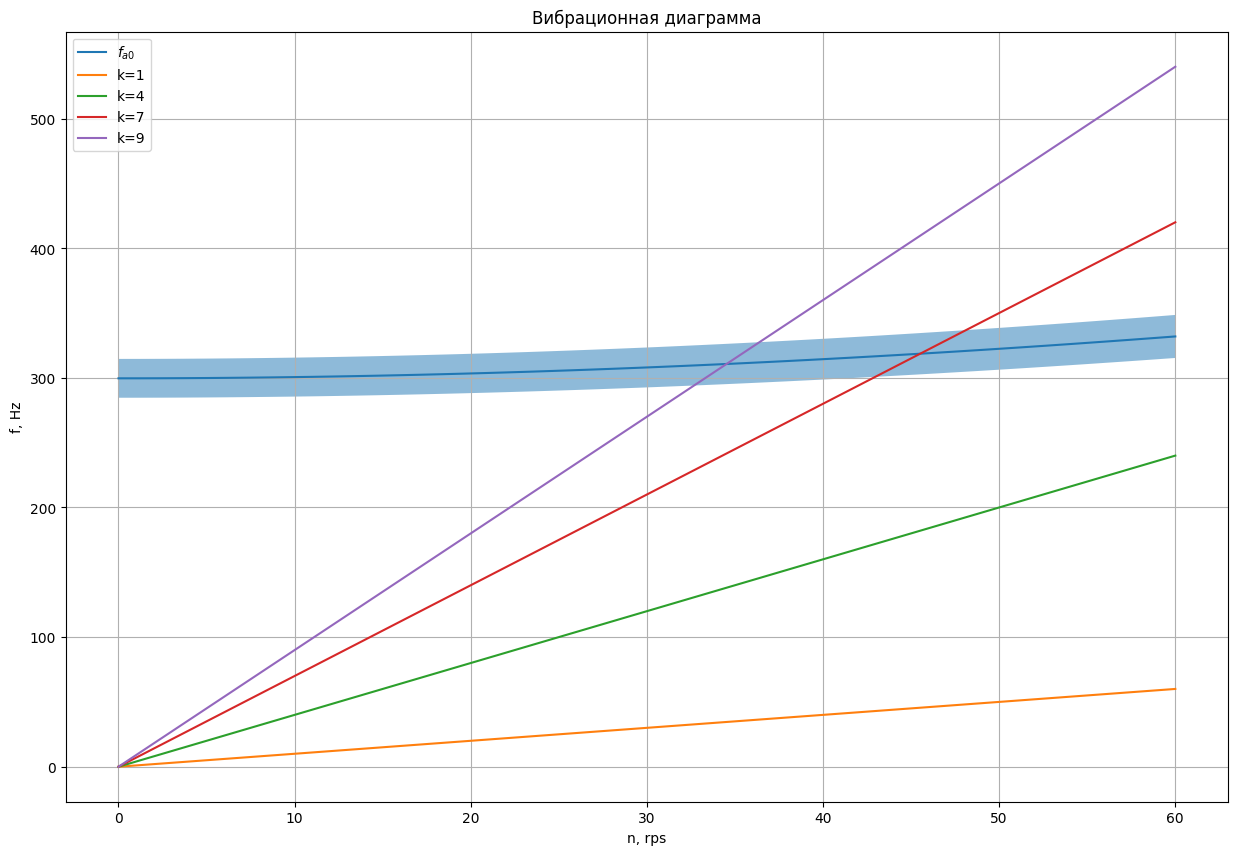

In [449]:
Dano.vibr_plot()